In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42

In [ ]:
features_dataset = pd.read_csv('/content/drive/MyDrive/ML/archive/data/Training_set_values.csv', index_col="id")
test_dataset = pd.read_csv('/content/drive/MyDrive/ML/archive/data/Test_set_values.csv', index_col="id")
labels_dataset = pd.read_csv('/content/drive/MyDrive/ML/archive/data/Training_set_labels.csv', index_col="id")

In [ ]:
X = features_dataset
test = test_dataset
y = labels_dataset

In [ ]:
X.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


class distribution

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64


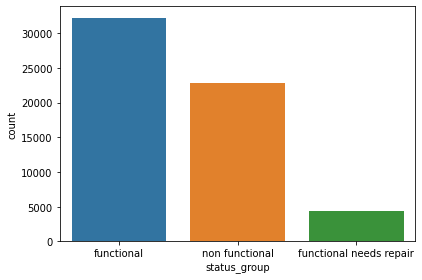

In [ ]:
print(y['status_group'].value_counts(normalize=True))
sns.countplot(x='status_group', data=y)
plt.tight_layout()


In [ ]:
print('\nNull Values in Training \n{}'.format(X.isnull().sum()))
print('\nNull Values in Testing \n{}'.format(test_dataset.isnull().sum()))
print('\nNull Values in Labels \n{}'.format(y.isnull().sum()))


print('\nDuplicated values in train {}'.format(X.duplicated().sum()))
print('Duplicated values in test {}'.format(test_dataset.duplicated().sum()))



Null Values in Training 
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group

In [ ]:
X.dtypes

amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_qual

In [ ]:
joined_train = X.join(y)

remove duplicates in train data

In [ ]:
#Drop duplicates
def drop_duplicates(df):
  df.drop_duplicates(subset=df.columns, keep="first", inplace=True)

drop_duplicates(joined_train)
print('Duplicated values in train {}'.format(joined_train.duplicated().sum()))


Duplicated values in train 0


In [ ]:
X = joined_train.iloc[:,:-1]

In [ ]:
X.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [ ]:
X.shape

(59364, 39)

The processings such as missing value imputation etc. are done using both train and test set featuers.

In [ ]:
df=X.append(test)
print(df.shape)

(74214, 39)


#Missing value imputation

* ```funder```-replace by 'other'.
* ```installer```-replace by 'other'.
* ```subvillage``` - using mode of subvillages grouped by region_code wise.
* ```public_meeting``` - using median.
* ```scheme managment``` - using mode of scheme_managment grouped by region wise.
* ```scheme name``` - using mode of scheme_name grouped by region wise.
* ```permit``` - using median.

In [ ]:
funder_l = list(map(str,df["funder"].unique()))
funder_l.sort()
print(funder_l)

In [ ]:
df['funder'].replace(to_replace=('0', 'nan', None), value='other', inplace=True)

In [ ]:
installer_l = list(map(str,df["installer"].unique()))
installer_l.sort()
print(installer_l)

In [ ]:
df['installer'].replace(to_replace=('0', 'nan', '-', None), value='other', inplace=True)

In [ ]:
subvillage_region_code = df.groupby(['region_code'])['subvillage'].agg(pd.Series.mode)
scheme_name_region_code = df.groupby(['region'])['scheme_name'].agg(pd.Series.mode)
scheme_management_region_code = df.groupby(['region'])['scheme_management'].agg(pd.Series.mode)

In [ ]:
def impute_mode(df,map_df,col,grouped_col):
  df.loc[df[col].isnull(),[col]] = df[df[col].isnull()].apply(
      lambda row: map_df.loc[row[grouped_col]][0],axis=1
  )

In [ ]:
impute_mode(df,subvillage_region_code,'subvillage','region_code')
impute_mode(df,scheme_name_region_code,'scheme_name','region')
impute_mode(df,scheme_management_region_code,'scheme_management','region')


In [ ]:
len(test)

14850

In [ ]:
public_meeting_median = df['public_meeting'].median()
permit_median = df['permit'].median()

In [ ]:
df.loc[df['public_meeting'].isnull(), 'public_meeting'] = public_meeting_median
df.loc[df['permit'].isnull(), 'permit'] = permit_median

## Remove values with low freqency

Removed the values in the columns ```funder``` and ```installer``` that occur with frequencies less than 20

In [ ]:
def remove_less_freq_val(df,col,t):
  cnt = df.groupby(col)[col].count()
  other_list = cnt[cnt<t].index.tolist()
  df[col].replace(to_replace=other_list, value='other', inplace=True)

In [ ]:
remove_less_freq_val(df,"installer",20)
remove_less_freq_val(df,"funder",20)

#longitude and latitudes

(0,0) logitude, latitude values were replaced by the mean (logitude,latitude) of the respective region_code

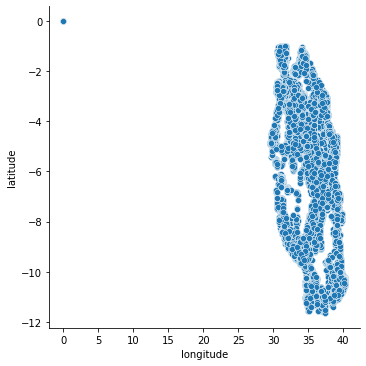

In [ ]:
sns.relplot(
    x="longitude", y="latitude", data=df
);

In [ ]:
df_geo = df.groupby(['region_code'])[['latitude', 'longitude']].mean()

In [ ]:
 df.loc[df['longitude'] == 0,['latitude', 'longitude']] = df[df['longitude']==0].apply(
     lambda row: df_geo.loc[row['region_code'],['latitude', 'longitude']],axis=1
)[['latitude', 'longitude']]

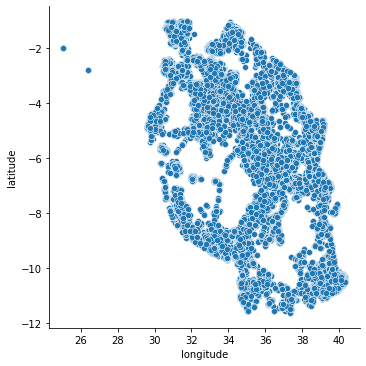

In [ ]:
sns.relplot(
    x="longitude", y="latitude", data=df
);

#Clustering 

A new feature ```Cluster``` was created by clustering longitudes and latitude based on ```population```.

In [ ]:
# clusturing of long and lattitude\
from sklearn.cluster import KMeans
import seaborn as sns

df_l = df.loc[:, ["population", "latitude", "longitude"]]
kmeans = KMeans(n_clusters=8, random_state=RANDOM_SEED)
df_l["Cluster"] = kmeans.fit_predict(df_l)
df_l["Cluster"] = df_l["Cluster"].astype("category")

df_l.head()

,population,latitude,longitude,Cluster
id,,,,
69572,109,-9.856322,34.938093,6
8776,280,-2.147466,34.698766,0
34310,250,-3.821329,37.460664,0
67743,58,-11.155298,38.486161,6
19728,0,-1.825359,31.130847,6


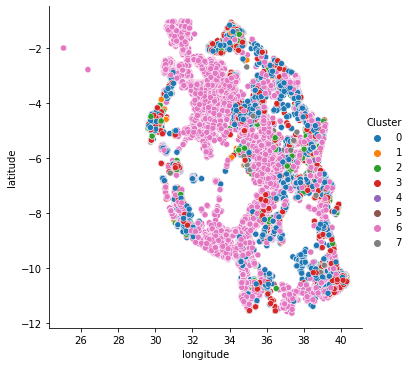

In [ ]:
sns.relplot(
    x="longitude", y="latitude", hue="Cluster", data=df_l
);

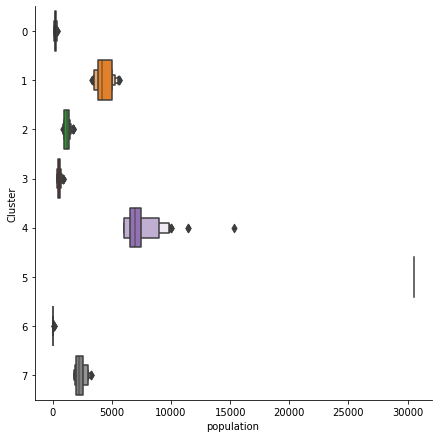

In [ ]:
df_l["population"]  = df["population"] 
sns.catplot(x="population", y="Cluster", data=df_l , kind="boxen", height=6);

In [ ]:
df["Cluster"] = df_l["Cluster"].astype("object")

## ```gps_height``` imputation

In [ ]:
df_gps = df.groupby(['region_code'])[['gps_height']].mean()

In [ ]:
 df.loc[df['gps_height'] == 0,['gps_height']] = df[df['gps_height']==0].apply(
     lambda row: df_gps.loc[row['region_code'],['gps_height']],axis=1
)[['gps_height']]

In [ ]:
df['gps_height'].value_counts()

0.000000       11026
46.430133       6095
0.055954        4173
148.226712      3340
546.299841       579
               ...  
2268.000000        1
2539.000000        1
2278.000000        1
2585.000000        1
2274.000000        1
Name: gps_height, Length: 2467, dtype: int64

## log normalize ```population```

In [ ]:
df.population = df.population.apply(lambda x: np.log10(x+1))

## Re-split data into train and test

In [ ]:
test = df[len(X):]
X = df[:len(X)]

print(X.shape)
print(test.shape)

(59364, 40)
(14850, 40)


In [ ]:
print('\nNull Values in Training \n{}'.format(X.isnull().sum()))
print('\nNull Values in Training \n{}'.format(test.isnull().sum()))


Null Values in Training 
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
scheme_name              0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
so

In [ ]:
len(X.columns)

40

In [ ]:
y = joined_train["status_group"]

In [ ]:
y.shape

(59364,)

In [ ]:
X.shape

(59364, 40)

In [ ]:
joined_processed_train = X.join(y)

In [ ]:
joined_processed_train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,Cluster,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390.000000,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,2.041393,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,6,functional
8776,0.0,2013-03-06,Grumeti,1399.000000,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,2.448706,1,GeoData Consultants Ltd,Other,M,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0,functional
34310,25.0,2013-02-25,other,686.000000,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,2.399674,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,0,functional
67743,0.0,2013-01-28,Unicef,263.000000,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,1.770852,True,GeoData Consultants Ltd,VWC,B,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,6,non functional
19728,0.0,2011-07-13,other,0.055954,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0.000000,True,GeoData Consultants Ltd,V,K,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,6,functional


In [ ]:
categorical_cols = ['funder', 'installer','wpt_name', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group']

int_cols = ["gps_height","num_private","population","construction_year"]

float_cols = ["amount_tsh","longitude","latitude"]

cols = categorical_cols+int_cols+float_cols+["date_recorded"]

In [ ]:
cat_cols = categorical_cols +["status_group"]

In [ ]:
joined_processed_train_cat = joined_processed_train.loc[:,cat_cols]

#Building-Up featuers

```date recorded``` columns was seperated into 2 featuers, ```year``` and ```month```

In [ ]:
joined_processed_train['date_recorded'] = pd.to_datetime(joined_processed_train['date_recorded'])
joined_processed_train['year'] = joined_processed_train['date_recorded'].dt.year
joined_processed_train['month'] = joined_processed_train['date_recorded'].dt.month
joined_processed_train.drop(columns = 'date_recorded', inplace = True)

In [ ]:
test['date_recorded'] = pd.to_datetime(test['date_recorded'])
test['year'] = test['date_recorded'].dt.year
test['month'] = test['date_recorded'].dt.month
test.drop(columns = 'date_recorded', inplace = True)

In [ ]:
joined_processed_train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,Cluster,status_group,year,month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,Roman,1390.000000,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,2.041393,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,6,functional,2011,3
8776,0.0,Grumeti,1399.000000,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,2.448706,1,GeoData Consultants Ltd,Other,M,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0,functional,2013,3
34310,25.0,other,686.000000,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,2.399674,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,0,functional,2013,2
67743,0.0,Unicef,263.000000,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,1.770852,True,GeoData Consultants Ltd,VWC,B,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,6,non functional,2013,1
19728,0.0,other,0.055954,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0.000000,True,GeoData Consultants Ltd,V,K,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,6,functional,2011,7


In [ ]:
test.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,Cluster,year,month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,0.0,Dmdd,1996.0,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,2.507856,True,GeoData Consultants Ltd,Parastatal,K,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,0,2013,2
51630,0.0,Government Of Tanzania,1569.0,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,2.478566,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,0,2013,2
17168,0.0,other,1567.0,other,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,2.699838,True,GeoData Consultants Ltd,VWC,P,1,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,3,2013,2
45559,0.0,Finn Water,267.0,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,2.399674,1,GeoData Consultants Ltd,VWC,G,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,0,2013,1
49871,500.0,Bruder,1260.0,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,1.785330,1,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,6,2013,3


In [ ]:
print(joined_processed_train.shape)
print(test.shape)

(59364, 42)
(14850, 41)


#Train CatBoostClassifier

split the dataset into train and test in a stratified manner to maintain a class distribution in both the splits, equal to that of the original dataset.

In [ ]:
X_selected = joined_processed_train.drop(columns=["status_group"])

In [ ]:
num_cols = int_cols+float_cols+['year','month']
cat_cols_selected = list(set(joined_processed_train.columns)-set(num_cols)-set(['status_group']))

In [ ]:
X_selected[cat_cols_selected] = X_selected[cat_cols_selected].astype('category')
test[cat_cols_selected] = test[cat_cols_selected].astype('category')

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, random_state = RANDOM_SEED, test_size=0.1,  stratify=y)

In [ ]:
!pip install catboost

     |████████████████████████████████| 67.4 MB 25 kB/s 


In [ ]:
 from catboost import CatBoostClassifier

 model = CatBoostClassifier(
        max_ctr_complexity=5,
        task_type='CPU',
        iterations=10000,
        eval_metric='AUC',
        od_type='Iter',
        od_wait=500,
        cat_features = cat_cols_selected,
        verbose=False
    )

In [ ]:
model.fit(X_train,y_train)

In [ ]:
pred = model.predict(X_test)

In [ ]:
pred

Accuracy Score:  0.8206164729661445


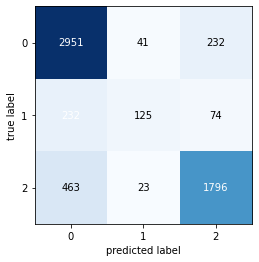

In [ ]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score

print("Accuracy Score: ", accuracy_score(y_test, pred))
cm = confusion_matrix(y_test, pred.flatten())
plot_confusion_matrix(cm)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics

print("   Accuracy: {}".format(metrics.accuracy_score(y_test, pred)))

print(classification_report(y_test,pred))

   Accuracy: 0.8206164729661445
                         precision    recall  f1-score   support

             functional       0.81      0.92      0.86      3224
functional needs repair       0.66      0.29      0.40       431
         non functional       0.85      0.79      0.82      2282

               accuracy                           0.82      5937
              macro avg       0.78      0.66      0.69      5937
           weighted avg       0.82      0.82      0.81      5937



#Create submission file

In [ ]:
model.fit(X_selected,y)

In [ ]:
X_validate = test
y_validate = model.predict(
    X_validate
)
df_predictions = pd.DataFrame(
    y_validate, 
    index=X_validate.index, 
    columns=['status_group']
)
df_predictions.to_csv(
    '/content/drive/MyDrive/ML/archive/data/submissions/submission15_tentative.csv'
)

In [ ]:
df_predictions.head(10)

,status_group
id,
50785,functional
51630,functional
17168,functional
45559,non functional
49871,functional
52449,functional
24806,non functional
28965,non functional
36301,non functional
